USEFUL LINKS FOR DATA CLEANING:

https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?utm_source=blog&utm_medium=stockmarketpredictionarticle

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.relataly.com/stock-market-prediction-with-multivariate-time-series-in-python/1815/

In [533]:
import pandas as pd
import calendar as cd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
import os

DIRTY_FILE_NAME = 'ES=F.csv'
CLEAN_FILE_NAME = '(Clean)dowjones_stocks.csv'

## DATA EXTRACTION AND CLEANING AND FORMATTING
### Data Extraction
Putting the dow jones csv data into a dataframe

In [534]:
if os.path.exists(DIRTY_FILE_NAME):
    dowjones_stocks = pd.read_csv(DIRTY_FILE_NAME)
    print(dowjones_stocks.head())
else:
    print("Error: Input file not found")

         Date     Open     High      Low   Close  Adj Close    Volume
0  2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
1  2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2  2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
3  2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
4  2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


### Data Cleaning

The Dow Jones stock price dataset contains a number of null records typically during holidays or weekends, which are days when the stock market is closed. To clean this dataset, we will simply remove all null records. Due to the missing dates, it should be noted that the stock price forecasting model will not predict stock prices for each subsequent days. Rather, we should assume that the forecasting model will predict stock prices for the next subsequent day in which the stock price would typically be observed and recorded.

In [535]:
dowjones_stocks_cleaned = dowjones_stocks.loc[dowjones_stocks["Open"].isnull() == False]
dowjones_stocks_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,1485.25,1489.75,1462.25,1467.50,1467.50,104794.0
1,2000-09-19,1467.00,1482.75,1466.75,1478.50,1478.50,103371.0
2,2000-09-20,1478.75,1480.50,1450.25,1469.50,1469.50,109667.0
3,2000-09-21,1470.25,1474.00,1455.50,1469.50,1469.50,98528.0
4,2000-09-22,1454.75,1471.00,1436.75,1468.50,1468.50,97416.0
...,...,...,...,...,...,...,...
6189,2020-11-16,3587.00,3637.00,3586.50,3623.00,3623.00,1303941.0
6190,2020-11-17,3625.50,3630.00,3584.25,3606.75,3606.75,1268206.0
6191,2020-11-18,3604.50,3623.25,3556.50,3565.00,3565.00,1325309.0
6192,2020-11-19,3562.00,3582.75,3542.25,3580.00,3580.00,1291117.0


Check if there are any null values left in the dataset. There are none left.

In [536]:
dowjones_stocks_cleaned.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [537]:
#save cleaned data without the index column.
dowjones_stocks_cleaned.to_csv(CLEAN_FILE_NAME, index=0)

PermissionError: [Errno 13] Permission denied: '(Clean)dowjones_stocks.csv'

## BREAK POINT 1: Data Cleaned and saved till here. Can begin from here if saved file is available

In [508]:
if os.path.exists(CLEAN_FILE_NAME):
    dowjones_stocks_cleaned = pd.read_csv(CLEAN_FILE_NAME,index_col=['Date'])
    print(dowjones_stocks_cleaned.head())
else:
    print("Error: Clean File not found. Restart from the beginning")

               Open     High      Low   Close  Adj Close    Volume
Date                                                              
2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


# Splitting the Data

We have 10 years worth of data. Will use 9 years of data to predict the last year.
Will break the data down into weekly data and then use that to predict the daily high for each daya for a week. We will also remove the "Adjusted Close" column as it is the same as the "Close" column.

In [509]:
dowjones_stocks_cleaned_copy = dowjones_stocks_cleaned.copy()
del dowjones_stocks_cleaned_copy["Adj Close"]
dowjones_stocks_cleaned_copy

,Open,High,Low,Close,Volume
Date,,,,,
2000-09-18,1485.25,1489.75,1462.25,1467.50,104794.0
2000-09-19,1467.00,1482.75,1466.75,1478.50,103371.0
2000-09-20,1478.75,1480.50,1450.25,1469.50,109667.0
2000-09-21,1470.25,1474.00,1455.50,1469.50,98528.0
2000-09-22,1454.75,1471.00,1436.75,1468.50,97416.0
...,...,...,...,...,...
2020-11-16,3587.00,3637.00,3586.50,3623.00,1303941.0
2020-11-17,3625.50,3630.00,3584.25,3606.75,1268206.0
2020-11-18,3604.50,3623.25,3556.50,3565.00,1325309.0


In [510]:
def split(dataset):
    dataset = dataset.values
    length = len(dataset)
    print("Length=",length)
    total_weeks = int(length/5)
    print("Total Weeks=",total_weeks)
    
    #use last 1 year as test data set, everything else as train dataset
    WEEKS_IN_ONE_YEAR = 52
    ONE_YEAR_WORK_DAYS = 5*52
    
    train = dataset[0:-ONE_YEAR_WORK_DAYS]
    test = dataset[-ONE_YEAR_WORK_DAYS:]
    
    #convert to array
    train = np.array(train)
    test = np.array(test)
    
    print("-----TRAIN DATA-----")
    print("Length=",len(train))
    print("-----TEST DATA-----")
    print("Length=",len(test))
    print(train[0])
    print(test[0])
    return train,test
    
train_data,test_data = split(dowjones_stocks_cleaned_copy)

Length= 5131
Total Weeks= 1026
-----TRAIN DATA-----
Length= 4871
-----TEST DATA-----
Length= 260
[  1485.25   1489.75   1462.25   1467.5  104794.  ]
[   3237.      3261.75    3234.25    3259.   1416241.  ]


### What to predict?
Use the available data: Open Price, High, Low, Close, Adj Close, Volume to predict the High of next 1 week

In [511]:
COLUMN_TO_PREDICT = 3 #Closing cost for the day
NUMBER_OF_DAYS_DATA_TO_USE = 15
NUMBER_OF_COLUMNS = train_data.shape[1]
NUMBER_OF_DAYS_DATA_TO_PREDICT = 5

#split the given data into inputs and outputs. We can use last 7 days data to predict the next day 
# or we can use monthly data to predict. It depends onm how we want to model the data
# and will experiment with various models
#if column_with_result is None, then trying to make data for validation
def convert_data_into_io(input_data, steps, column_with_result, num_of_days_to_predict):
    print(column_with_result)
    x,y = list(), list()
    
    for i in range(len(input_data)):
        end = i + steps
        if end+1 > len(input_data) or end+num_of_days_to_predict > len(input_data):
            break
        
        _x = input_data[i:end,]
        _y = input_data[end:end+num_of_days_to_predict,column_with_result]
        
        y.append(_y)
        x.append(_x)
        
    return np.array(x), np.array(y)

In [512]:
train_x,train_y = convert_data_into_io(train_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Train Data:", len(train_x))
print("Sample Train Input Data:")
print(train_x[0])
print("Sample Train Output Data:")
print(train_y[0])
print("------------------------")

test_x,test_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Test Data:", len(test_x))
print("Sample Test Input Data:")
print(test_x[0])
print("Sample Test Output Data:")
print(test_y[0])
print("-------------------------")

3
------------------------
Total Train Data: 4852
Sample Train Input Data:
[[  1485.25   1489.75   1462.25   1467.5  104794.  ]
 [  1467.     1482.75   1466.75   1478.5  103371.  ]
 [  1478.75   1480.5    1450.25   1469.5  109667.  ]
 [  1470.25   1474.     1455.5    1469.5   98528.  ]
 [  1454.75   1471.     1436.75   1468.5   97416.  ]
 [  1469.5    1477.75   1455.5    1461.    85491.  ]
 [  1461.     1467.     1442.5    1443.    99803.  ]
 [  1444.     1456.     1438.25   1446.75 101996.  ]
 [  1447.75   1481.     1445.     1476.    84280.  ]
 [  1473.     1473.25   1454.     1454.    78277.  ]
 [  1453.75   1464.25   1447.5    1456.25  84100.  ]
 [  1457.25   1474.     1438.75   1441.5   89440.  ]
 [  1442.     1457.25   1432.5    1450.25 101607.  ]
 [  1449.5    1462.     1447.25   1456.    92232.  ]
 [  1456.     1460.5    1411.5    1426.25  95257.  ]]
Sample Train Output Data:
[1416.5  1391.   1378.5  1344.   1386.25]
------------------------
3
------------------------
Total Tes

## LSTM Model (100 EPOCHS)
Creating a 5 day closing stock price forecasting model with LSTM with 100 epochs

In [513]:
# Number of epochs
epochs = 100

# Number of features
num_features = train_x.shape[2]

# name of model and history 
model_name_1 = "stock_model_1.h5"
history_name_1 = "stock_model_history_1.csv"

# The model
def stock_model(num_features, epochs, model_name, history_name):
    stock_model = keras.Sequential()
    stock_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(NUMBER_OF_DAYS_DATA_TO_USE, num_features)))
    stock_model.add(LSTM(100, activation='relu'))
    stock_model.add(Dense(NUMBER_OF_DAYS_DATA_TO_PREDICT))

    print(stock_model.summary())
    
    stock_model.compile(optimizer='adam', loss='mae')
    stock_model_history = stock_model.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y))
    
    stock_model.save(model_name)

    pd.DataFrame(stock_model_history.history).to_csv(history_name)
    
    return stock_model, stock_model_history

Loading the forecasting model with 100 epochs if it exists. If not, run the forecasting model and fit a new model.

In [514]:
#SAVE MODEL AFTER FITTING. If saved model is available, then reload that
model = None
model_history = pd.DataFrame()

if os.path.exists(model_name_1):
    print("Model Found: Loading...")
    model = load_model(model_name_1)
    model_history = pd.read_csv(history_name_1)
    print(model.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model, model_history = stock_model(num_features, epochs, model_name_1, history_name_1)
    model_history = model_history.history

Model not Found. Fitting model...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 15, 100)           42400     
_________________________________________________________________
lstm_51 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 505       
Total params: 123,305
Trainable params: 123,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
152/152 [==============================] - 2s 16ms/step - loss: 36538.6094 - val_loss: 4994.9536
Epoch 2/100
152/152 [==============================] - 2s 13ms/step - loss: 2079.6599 - val_loss: 2143.5337
Epoch 3/100
152/152 [==============================] - 2s 13ms/step - loss: 2589.1304 - val_loss: 2204.7068
Epoch 4/100
1

152/152 [==============================] - 2s 13ms/step - loss: 148.2002 - val_loss: 623.9214
Epoch 71/100
152/152 [==============================] - 2s 13ms/step - loss: 258.3700 - val_loss: 386.3528
Epoch 72/100
152/152 [==============================] - 2s 13ms/step - loss: 159.7715 - val_loss: 337.7796
Epoch 73/100
152/152 [==============================] - 2s 13ms/step - loss: 111.1495 - val_loss: 242.4911
Epoch 74/100
152/152 [==============================] - 2s 13ms/step - loss: 72.1494 - val_loss: 164.1165
Epoch 75/100
152/152 [==============================] - 2s 13ms/step - loss: 67.7684 - val_loss: 163.0046
Epoch 76/100
152/152 [==============================] - 2s 13ms/step - loss: 58.0706 - val_loss: 160.9075
Epoch 77/100
152/152 [==============================] - 2s 13ms/step - loss: 74.9234 - val_loss: 201.4078
Epoch 78/100
152/152 [==============================] - 2s 13ms/step - loss: 70.2063 - val_loss: 198.0408
Epoch 79/100
152/152 [==============================] -

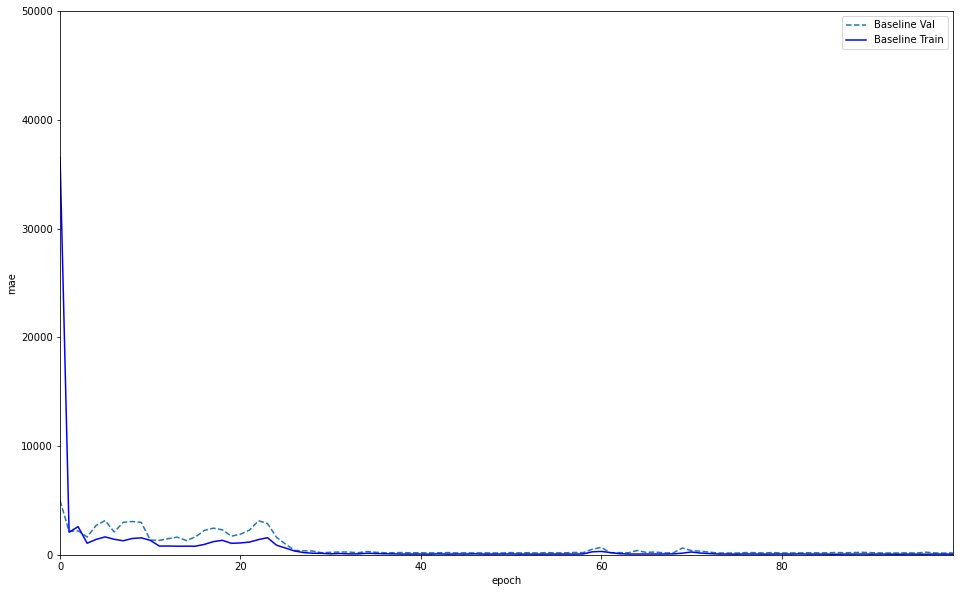

In [515]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), model_history['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), model_history['loss'], color='blue', label='Baseline Train')
plt.ylabel("mae")
plt.xlabel("epoch")
plt.xlim([0,max(np.arange(0,epochs,1))])
plt.ylim([0,50000])
plt.legend()
plt.show()

In [516]:
#function for preditions and error calculating
def predict(model, input_data):
    input_data = input_data.reshape(1,NUMBER_OF_DAYS_DATA_TO_USE,NUMBER_OF_COLUMNS)
    value = model.predict(input_data, verbose=0)
    return value[0][0]

def check_all_test_data(data, model):
    predicted_data = []
    i = 1
    for d in data:
        print('.',end='')
        if i%20 == 0: print('-',i)
        d = d.reshape((1, NUMBER_OF_DAYS_DATA_TO_USE, NUMBER_OF_COLUMNS))
        data = predict(model,d)
        predicted_data.append(data)
        i = i+1
    print('-',i)
    return predicted_data

In [517]:
test_x,actual_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("Start predicting data...")
predicted_y = check_all_test_data(test_x, model)
print("End of data prediction!")

3
Start predicting data...
....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


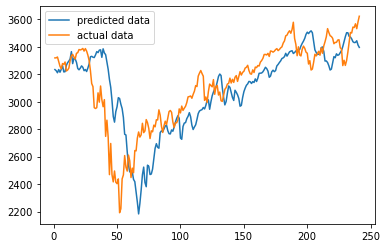

In [518]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import math 

#plot actual and predicted
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y, label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()


RMSE =  219.7253445643338


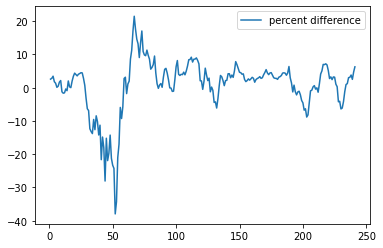

In [519]:
#print RMSE
mse = mean_squared_error(actual_y[:,0], predicted_y)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i,0],predicted_y[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## LSTM MODEL (200 EPOCHS)
Creating a 5 day closing stock price forecasting model with LSTM with 200 epochs

In [520]:
epochs_2 = 200
model_name_2 = "stock_model_2.h5"
history_name_2 = "stock_model_history_2.csv"

In [521]:
model_2 = None
model_history_2 = pd.DataFrame()

if os.path.exists(model_name_2):
    print("Model Found: Loading...")
    model_2 = load_model(model_name_2)
    model_history_2 = pd.read_csv(history_name_2)
    print(model_2.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model_2, model_history_2 = stock_model(num_features, epochs_2, model_name_2, history_name_2)
    model_history_2 = model_history_2.history

Model not Found. Fitting model...
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 15, 100)           42400     
_________________________________________________________________
lstm_53 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 505       
Total params: 123,305
Trainable params: 123,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
152/152 [==============================] - 2s 16ms/step - loss: 78206.2031 - val_loss: 38390.9219
Epoch 2/200
152/152 [==============================] - 2s 13ms/step - loss: 11218.2295 - val_loss: 11558.0010
Epoch 3/200
152/152 [==============================] - 2s 13ms/step - loss: 9098.6641 - val_loss: 3927.9316
Epoch 4/20

152/152 [==============================] - 2s 13ms/step - loss: 86.4609 - val_loss: 216.8248
Epoch 70/200
152/152 [==============================] - 2s 13ms/step - loss: 86.5235 - val_loss: 195.0522
Epoch 71/200
152/152 [==============================] - 2s 13ms/step - loss: 87.0067 - val_loss: 192.4664
Epoch 72/200
152/152 [==============================] - 2s 13ms/step - loss: 77.7595 - val_loss: 277.1082
Epoch 73/200
152/152 [==============================] - 2s 13ms/step - loss: 113.5603 - val_loss: 223.9302
Epoch 74/200
152/152 [==============================] - 2s 13ms/step - loss: 92.8762 - val_loss: 265.0374
Epoch 75/200
152/152 [==============================] - 2s 13ms/step - loss: 94.2613 - val_loss: 232.0270
Epoch 76/200
152/152 [==============================] - 2s 14ms/step - loss: 83.4068 - val_loss: 256.1994
Epoch 77/200
152/152 [==============================] - 2s 13ms/step - loss: 146.9259 - val_loss: 412.2501
Epoch 78/200
152/152 [==============================] - 2

Epoch 146/200
152/152 [==============================] - 2s 13ms/step - loss: 54.2100 - val_loss: 167.1799
Epoch 147/200
152/152 [==============================] - 2s 13ms/step - loss: 56.0696 - val_loss: 172.6575
Epoch 148/200
152/152 [==============================] - 2s 14ms/step - loss: 62.7080 - val_loss: 205.0775
Epoch 149/200
152/152 [==============================] - 2s 13ms/step - loss: 58.2114 - val_loss: 190.7229
Epoch 150/200
152/152 [==============================] - 2s 14ms/step - loss: 66.5201 - val_loss: 232.9354
Epoch 151/200
152/152 [==============================] - 2s 13ms/step - loss: 64.3269 - val_loss: 176.7438
Epoch 152/200
152/152 [==============================] - 2s 13ms/step - loss: 53.4788 - val_loss: 166.4877
Epoch 153/200
152/152 [==============================] - 2s 13ms/step - loss: 84.7431 - val_loss: 174.2542
Epoch 154/200
152/152 [==============================] - 2s 13ms/step - loss: 59.1568 - val_loss: 202.5521
Epoch 155/200
152/152 [==============

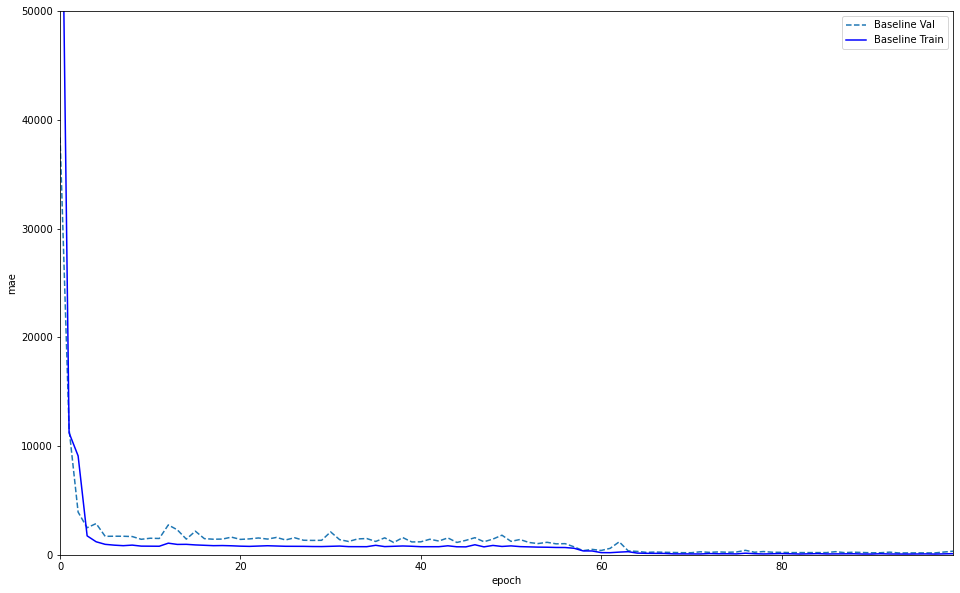

In [523]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs_2,1), model_history_2['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs_2,1), model_history_2['loss'], color='blue', label='Baseline Train')
plt.ylabel("mae")
plt.xlabel("epoch")
plt.xlim([0,max(np.arange(0,epochs,1))])
plt.ylim([0,50000])
plt.legend()
plt.show()

In [524]:
predicted_y_2 = check_all_test_data(test_x, model_2)
print("End of data prediction!")

....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


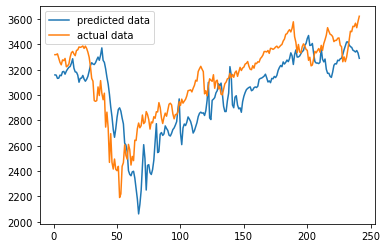

In [525]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y_2, label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

RMSE =  241.19108264139544


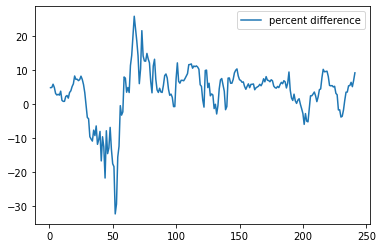

In [526]:
#print RMSE
mse = mean_squared_error(actual_y[:,0], predicted_y_2)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i,0],predicted_y_2[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## LSTM MODEL (300 EPOCHS)
Creating a 5 day closing stock price forecasting model with LSTM with 300 epochs

In [527]:
epochs_3 = 300
model_name_3 = "stock_model_3.h5"
history_name_3 = "stock_model_history_3.csv"

In [528]:
model_3 = None
model_history_3 = pd.DataFrame()

if os.path.exists(model_name_3):
    print("Model Found: Loading...")
    model_3 = load_model(model_name_3)
    model_history_3 = pd.read_csv(history_name_3)
    print(model_3.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model_3, model_history_3 = stock_model(num_features, epochs_3, model_name_3, history_name_3)
    model_history_3 = model_history_3.history

Model not Found. Fitting model...
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 15, 100)           42400     
_________________________________________________________________
lstm_55 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 505       
Total params: 123,305
Trainable params: 123,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
152/152 [==============================] - 2s 16ms/step - loss: 58037.5273 - val_loss: 50839.8438
Epoch 2/300
152/152 [==============================] - 2s 14ms/step - loss: 18357.5254 - val_loss: 20600.0801
Epoch 3/300
152/152 [==============================] - 2s 13ms/step - loss: 6357.1260 - val_loss: 6119.2739
Epoch 4/30

152/152 [==============================] - 2s 13ms/step - loss: 61.4814 - val_loss: 159.4004
Epoch 71/300
152/152 [==============================] - 2s 13ms/step - loss: 55.9092 - val_loss: 159.7817
Epoch 72/300
152/152 [==============================] - 2s 13ms/step - loss: 60.8386 - val_loss: 161.7382
Epoch 73/300
152/152 [==============================] - 2s 13ms/step - loss: 59.4201 - val_loss: 202.1632
Epoch 74/300
152/152 [==============================] - 2s 13ms/step - loss: 63.4769 - val_loss: 177.1120
Epoch 75/300
152/152 [==============================] - 2s 13ms/step - loss: 54.6652 - val_loss: 160.8114
Epoch 76/300
152/152 [==============================] - 2s 13ms/step - loss: 55.6517 - val_loss: 194.6451
Epoch 77/300
152/152 [==============================] - 2s 13ms/step - loss: 55.3999 - val_loss: 161.9975
Epoch 78/300
152/152 [==============================] - 2s 13ms/step - loss: 59.6966 - val_loss: 177.9992
Epoch 79/300
152/152 [==============================] - 2s 

Epoch 147/300
152/152 [==============================] - 2s 13ms/step - loss: 54.4342 - val_loss: 169.7037
Epoch 148/300
152/152 [==============================] - 2s 13ms/step - loss: 52.4317 - val_loss: 172.2283
Epoch 149/300
152/152 [==============================] - 2s 13ms/step - loss: 53.0618 - val_loss: 159.6802
Epoch 150/300
152/152 [==============================] - 2s 13ms/step - loss: 51.8321 - val_loss: 165.7251
Epoch 151/300
152/152 [==============================] - 2s 13ms/step - loss: 58.0353 - val_loss: 180.2871
Epoch 152/300
152/152 [==============================] - 2s 13ms/step - loss: 54.3232 - val_loss: 171.3706
Epoch 153/300
152/152 [==============================] - 2s 14ms/step - loss: 48.1689 - val_loss: 184.6590
Epoch 154/300
152/152 [==============================] - 2s 13ms/step - loss: 53.9752 - val_loss: 158.5234
Epoch 155/300
152/152 [==============================] - 2s 13ms/step - loss: 56.1222 - val_loss: 171.7144
Epoch 156/300
152/152 [==============

152/152 [==============================] - 2s 13ms/step - loss: 49.6847 - val_loss: 167.5808
Epoch 224/300
152/152 [==============================] - 2s 13ms/step - loss: 50.1591 - val_loss: 168.8891
Epoch 225/300
152/152 [==============================] - 2s 13ms/step - loss: 50.0988 - val_loss: 158.7215
Epoch 226/300
152/152 [==============================] - 2s 13ms/step - loss: 46.4362 - val_loss: 168.6829
Epoch 227/300
152/152 [==============================] - 2s 13ms/step - loss: 52.9696 - val_loss: 165.4498
Epoch 228/300
152/152 [==============================] - 2s 13ms/step - loss: 47.9389 - val_loss: 162.3984
Epoch 229/300
152/152 [==============================] - 2s 13ms/step - loss: 48.2967 - val_loss: 191.6125
Epoch 230/300
152/152 [==============================] - 2s 13ms/step - loss: 49.0978 - val_loss: 161.7267
Epoch 231/300
152/152 [==============================] - 2s 13ms/step - loss: 48.8721 - val_loss: 160.1912
Epoch 232/300
152/152 [============================

152/152 [==============================] - 2s 13ms/step - loss: 45.9604 - val_loss: 189.7622
Epoch 300/300
152/152 [==============================] - 2s 13ms/step - loss: 50.6227 - val_loss: 160.6523


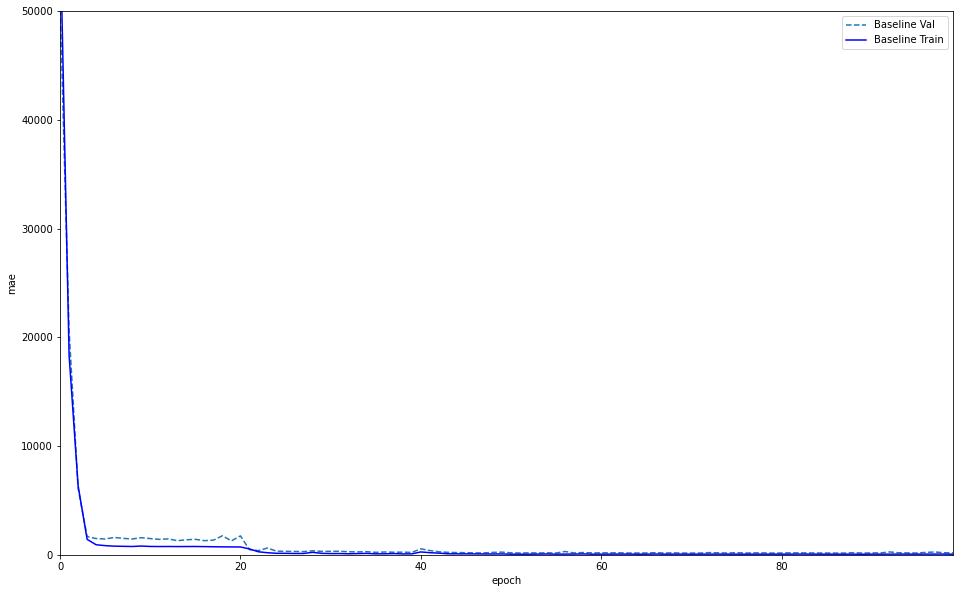

In [529]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs_3,1), model_history_3['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs_3,1), model_history_3['loss'], color='blue', label='Baseline Train')
plt.ylabel("mae")
plt.xlabel("epoch")
plt.xlim([0,max(np.arange(0,epochs,1))])
plt.ylim([0,50000])
plt.legend()
plt.show()

In [530]:
predicted_y_3 = check_all_test_data(test_x, model_3)
print("End of data prediction!")

....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


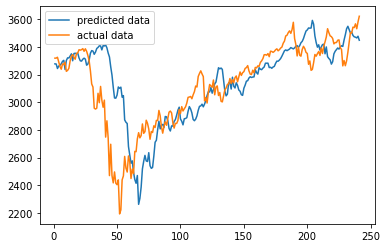

In [531]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y_3, label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

RMSE =  228.6385325617081


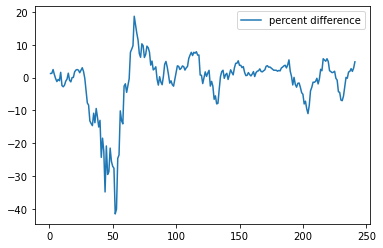

In [532]:
#print RMSE
mse = mean_squared_error(actual_y[:,0], predicted_y_3)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i,0],predicted_y_3[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()